# Summary 

Here I try to code an AI to deal solve the game of Toot and Otto (kind of like connect four - you can probably already guess what the game is from here). It is an interesting spin and one I decided to try to solve. 

From the start I had a feeling that policy gradients wouldn't be the best for such a problem. Either way I went ahead with it hoping that the problem would be simple enough to solve without MCTS (that will be the next iteration of algorithms I create - not ready for that now lolrip). The reason this project failed was not because of this decision however. The problem stems from the fact that this environment is not the classical MDP I have faced before. It is a zero sum game where naively letting the agent play against itself (self-play) leads to convergence around suboptimal policies - ones that converges when playing against each other but are no where near the nash equilibrium or optimal policy (this is seen when it horribly loses against a random bot after training - infact, it does better before training). When training against a random agent, it does not converge (The messy repeated code is my desperation attempt to salvage the algorithm by using this method of direct play). This may be due to the incorrect formulation of the problem setting I am using. It is interesting because the Tic Tac Toe DQN did converge to a number. This may be because Policy Gradients are more complicated and so the effect is multiplied, also this problem space is much more difficult, running this algorithm on Tic Tac Toe could lead to some further insight about why DQN still works. Finally, DQN may not have the same problems due to it's implicit modelling of the policy. Updating the value of a state is very different from updating an agent to beat itself.

I think the steps to take are clear. I need to do some more theoretical research, and understand why this problem mathematically arises. I also need to learn how this situation is formally dealt with. 


In [1]:
import numpy as np
from collections import deque
import time
from itertools import product 

import tensorflow as tf                        # Fast machine learning 
from tensorflow.keras import layers            # Makes it easier to use functional API
from typing import Any, List, Sequence, Tuple  # Lets us use type checking by giving us names to call
import matplotlib.pyplot as plt

eps = np.finfo(np.float32).eps.item()

In [2]:
class board:
    
    def __init__(self):    
        #Game specific Variables
        self.moves_left = 24
        self.turn = 1
        
        #These two variables keep track of the state and how much the player can place 
        self.state = np.array([[0 for _ in range(6)] for __ in range(4)], dtype=np.float32)
        self.level = np.array([0 for _ in range(6)], dtype=np.int32) #Represents height of the column (must be less than 4!)
        
        #Each row represents one player's chips. 
        self.chips = np.array([[6, 6], [6, 6]], dtype=np.int32) 

        # First row represents player 1, second row represents player 2
        # First 6 actions represent a 1 in the column, the next 6 represent a -1 in the column
        self.mask = np.array([[1 for _ in range(12)] for _ in range(2)])
        
    @staticmethod
    def check(tup):
        a, b, c, d = tup 
        if a == 1 and b == -1 and c == -1 and d == 1: 
            return 1
        elif a == -1 and b == 1 and c == 1 and d == -1: 
            return -1 
        return 0 
        
    def calculate_winner(self):
        pts = 0 
        #Horizontal Check 
        for i, j in product(range(4), range(3)):
            pts += self.check(self.state[i][j: j+4])
            
        #Vertical Check 
        for i in range(6): 
            pts += self.check(self.state[:, i])
            
        #Diagonal Check
        for i in range(3): 
            pts += self.check([self.state[0][i], self.state[1][i+1], self.state[2][i+2], self.state[3][i+3]])
            pts += self.check([self.state[3][i], self.state[2][i+1], self.state[1][i+2], self.state[0][i+3]])
            
        return pts
                
    def update(self, action):
        action = int(action)
        chip = action//6
        loc = action%6

        placed = 1 if chip == 0 else -1
        player = 0 if self.turn == 1 else 1
        
        if self.level[loc] > 3: 
            raise ValueError("Too many chips in column!", self.state, self.turn, self.moves_left, self.level, self.chips, action)
            return "invalid move"
        
        if self.chips[player][chip] <= 0: 
            raise ValueError("Not enough chips", self.state, self.turn, self.moves_left, self.level, self.chips, action)
            return "invalid move"
        
        self.state[3-self.level[loc]][loc] = placed
        self.level[loc] += 1
        self.chips[player][chip] -= 1
        self.moves_left -= 1
        self.turn = (self.turn == 1)*(-1)+(self.turn == -1)*(1)
        
        if self.level[loc] == 4: 
            #Change masks of both players to not play on that column for either chip
            self.mask[0][[loc, loc+6]] = 0
            self.mask[1][[loc, loc+6]] = 0

        if self.chips[player][chip] == 0: 
            self.mask[player][6*chip:6*chip+6] = 0
            
        if self.moves_left: 
            return "valid move"
        else: 
            pts = self.calculate_winner()
            if pts > 0: 
                winner = 1 
            elif pts == 0: 
                winner = 0 
            else: 
                winner = -1 
            return f"{winner} won"
        
    def reset(self):
        self.moves_left = 24
        self.turn = 1
        
        self.state = np.array([[0 for _ in range(6)] for __ in range(4)], dtype = np.float32)
        self.level = np.array([0 for _ in range(6)], dtype = np.int32) #Represents height of the column (must be less than 4!)
        
        self.chips = np.array([[6, 6], [6, 6]], dtype=np.int32) 
        self.mask = np.array([[1 for _ in range(12)] for _ in range(2)], dtype = np.float32)

class game:
    
    def __init__(self):
        #RL Variables
        self.terminal = False
        self.reward = 0
        
        #Tic Tac Toe Board
        self.gameboard = board()
        
    def step(self, action):                    
        result = self.gameboard.update(action)
        
        if result == 'invalid move':
            self.reward = -1
            self.terminal = True
            
        elif result == 'valid move':
            self.reward = 0
            self.terminal = False
            
        elif result == '1 won':
            self.reward = 1
            self.terminal = True
            
        elif result == '-1 won':
            self.reward = -1
            self.terminal = True
        
        elif result == '0 won':
            self.reward = 0
            self.terminal = True
            
        return self.get_state_features(), self.get_mask(), self.reward, self.terminal
    
    def reset(self):
        self.gameboard.reset()
        
        self.terminal = False
        self.reward = 0
        return self.get_state_features(), self.get_mask()        
    
    def get_state_features(self):
        return self.gameboard.state.reshape(-1) * self.gameboard.turn

    def get_mask(self):
        player = 0 if self.gameboard.turn == 1 else 1
        return self.gameboard.mask[player]
    
    def render(self):
        def convert(n):
            n = int(n)
            return "T"*(n==1) + " "*(n==0) + "O"*(n==-1)
        
        print(f"Player 1 chips: {self.gameboard.chips[0][0]} T's and {self.gameboard.chips[0][1]} O's")
        print(f"Player 2 chips: {self.gameboard.chips[1][0]} T's and {self.gameboard.chips[1][1]} O's")
        for row in self.gameboard.state: 
            for col in row[:-1]: 
                print(convert(col), end = " | ")
            print(convert(row[-1]))

In [3]:
env = game()

In [4]:
class human:
    def evaluate(self, s):
        return "IS A PLAYER"
    
    def choose_action(self, s, m):
        return int(input("Where would you like to move? "))
    
class random_bot: 
    def evaluate(self, s):
        return "IS A RANDOM BOT"
    
    def choose_action(self, s, m):
        return (np.random.uniform(low = 0.5, high = 1, size=[12]) * m).argmax()

In [5]:
def simulate(players = [random_bot(), random_bot()], display = True, steps = 24): 

    b = game()    
    s, m = b.reset()

    playing = 0 
    for t in range(steps):
        if display: print(f"player {playing} thinks values are {players[playing].evaluate(s)}")
        if display: b.render()
            
        a = players[playing].choose_action(s, m)
        s, m, r, done = b.step(a)
        
        if display: print(f"action was {a} and the reward was {r}\n")
        if done: break
        
        playing = 0 if playing == 1 else 1 
    
    if display: b.render()
    return b.reward, b

def arena(players = [random_bot(), random_bot()], display = False, num_games = 10000): 
    p1_wins, p2_wins, draws = 0, 0, 0
    for i in range(1, num_games+1):
        winner, b = simulate(players, display)
        if winner > 0: 
            p1_wins += 1 
        elif winner < 0: 
            p2_wins += 1
        else: 
            draws += 1
                    
        if i%100==0:
            msg1 = f'player 1 {str(players[0].__class__)[17:-2]} won {p1_wins} times'
            msg2 = f' and player 2 {str(players[1].__class__)[17:-2]} won {p2_wins} times.' 
            msg3 = f' They drew {draws} times.'
            msg4 = f' They played {i} games.    '
            print(msg1 + msg2 + msg3 + msg4 + '        ', end = '\r')    

In [6]:
arena(num_games = 1000)

In [7]:
class ActorCritic(tf.keras.Model):
    """Combined actor-critic network"""
    
    def __init__(self, num_actions: int, num_hidden_units: List[int]):
        """Initialize."""
        super().__init__()
        self.common = layers.Dense(num_hidden_units[0])
        self.common2 = layers.Dense(num_hidden_units[1])
        self.actor = layers.Dense(num_actions)
        self.critic = layers.Dense(1)
        
    def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        x = self.common(inputs)
        x2 = self.common2(x)
        return self.actor(x2), self.critic(x2)

class Agent:
    def __init__(self, num_actions: int = 12, num_hidden_units: List[int] = [128, 64], gamma: int = 1):
        self.model = ActorCritic(num_actions, num_hidden_units)
        self.gamma = gamma
    
    @tf.function()
    def evaluate(self, s):
        s = tf.expand_dims(s, 0)
        return self(s)
    
    @tf.function()
    def choose_action(self, s, m):
        s, mask = [tf.expand_dims(x, 0) for x in [s, m]]
        probs, _ = self(s)
        
        mask_bool = tf.cast(mask, dtype = tf.bool)
        adj = tf.where(mask_bool, probs, -1e+8)
        probs = tf.nn.softmax(adj)
        
        return tf.cast(tf.argmax(probs[0]), tf.int32)
    
    @tf.function()
    def __call__(self, s): 
        return self.model(s)
        
def init_agent(gamma = 1): 
    a = Agent(gamma = gamma)
    a.evaluate(game().reset()[0])
    return a

In [8]:
agent = init_agent()

In [9]:
simulate(players = [agent, random_bot()], display = False)

(0, <__main__.game at 0x24965f29a60>)

In [10]:
arena(players = [agent, random_bot()], num_games = 100)

In [11]:
def reset() -> List[tf.Tensor]:
    return tf.numpy_function(env.reset, [], [tf.float32, tf.float32])

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    state, mask, reward, done = env.step(action)
    return state.astype(np.float32), mask.astype(np.float32), np.array(reward), np.array(done, np.int32)

def tf_env_step(action: tf.Tensor):
    return tf.numpy_function(env_step, [action], [tf.float32, tf.float32, tf.int32, tf.int32])

@tf.function()
def run_episode(initial_state: tf.Tensor, initial_mask: tf.Tensor, agent: Agent) -> List[tf.Tensor]:
    
    action_probs = tf.TensorArray(dtype = tf.float32, size = 0, dynamic_size = True)
    values = tf.TensorArray(dtype = tf.float32, size = 0, dynamic_size = True)
    rewards = tf.TensorArray(dtype = tf.int32, size = 0, dynamic_size = True)
    
    action_probs_2 = tf.TensorArray(dtype = tf.float32, size = 0, dynamic_size = True)
    values_2 = tf.TensorArray(dtype = tf.float32, size = 0, dynamic_size = True)
    rewards_2 = tf.TensorArray(dtype = tf.int32, size = 0, dynamic_size = True)
    
    initial_state_shape = initial_state.shape
    state = initial_state 
    
    initial_mask_shape = initial_mask.shape
    mask = initial_mask 
    
    for t in tf.range(12): 
        #Get state/mask into shape
        state = tf.expand_dims(state, 0)
        mask = tf.expand_dims(mask, 0)
        mask_bool = tf.cast(mask, dtype = tf.bool)
        
        #Get probabilities and apply mask to them
        action_logits_t, value = agent(state)
        adj = tf.where(mask_bool, action_logits_t, -1e+8)
        
        #Choose action and get probabilities 
        action = tf.random.categorical(adj, 1)[0, 0]
        action_probs_t = tf.nn.softmax(adj)
        
        #Store values and probabilities
        values = values.write(t, tf.squeeze(value)) #Squeezing gets rid of the batch aspect
        action_probs = action_probs.write(t, action_probs_t[0, action])
        
        #Advance to the next stage 
        state, mask, reward, done = tf_env_step(action)
        state.set_shape(initial_state_shape)
        mask.set_shape(initial_mask_shape)
        
        ############### Second player moves 
        
        #Similar deal, get state/mask into shape
        state = tf.expand_dims(state, 0)
        mask = tf.expand_dims(mask, 0)
        mask_bool = tf.cast(mask, dtype = tf.bool)
        
        #Get probabilities and apply mask to them
        action_logits_t_2, value_2 = agent(state)
        adj_2 = tf.where(mask_bool, action_logits_t_2, -1e+8)
        
        #Choose action and get probabilities 
        action_2 = tf.random.categorical(adj_2, 1)[0, 0]
        action_probs_t_2 = tf.nn.softmax(adj_2)
        
        #Store values and probabilities
        values_2 = values_2.write(t, tf.squeeze(value_2)) #Squeezing gets rid of the batch aspect
        action_probs_2 = action_probs_2.write(t, action_probs_t_2[0, action_2])
        
        #Advance to the next stage 
        state, mask, reward, done = tf_env_step(action_2)
        state.set_shape(initial_state_shape)
        mask.set_shape(initial_mask_shape)
        
        #Intensionally use same reward: This means that p1 and p2 both use the second reward in a sequence. 
        #Allows for both to access winning reward. Since the game returns the true winner, p2 has to multiply by negative 1 
        rewards = rewards.write(t, reward)
        rewards_2 = rewards_2.write(t, reward*-1)
        
    action_probs = action_probs.stack()
    values = values.stack()
    rewards = rewards.stack()
    
    action_probs_2 = action_probs_2.stack()
    values_2 = values_2.stack()
    rewards_2 = rewards_2.stack()
    
    return [action_probs, values, rewards], [action_probs_2, values_2, rewards_2]

In [12]:
run_episode(*reset(), agent)
run_episode(*reset(), agent)

([<tf.Tensor: shape=(12,), dtype=float32, numpy=
  array([0.08333334, 0.0870977 , 0.1161226 , 0.07653689, 0.08573595,
         0.12388834, 0.08547961, 0.0906362 , 0.10513576, 0.26571584,
         0.50966215, 0.58264416], dtype=float32)>,
  <tf.Tensor: shape=(12,), dtype=float32, numpy=
  array([0.        , 0.38940352, 0.5622256 , 0.3527979 , 0.36429882,
         0.63375   , 0.45862365, 0.43792194, 0.5889814 , 0.44887596,
         0.4393671 , 0.3982233 ], dtype=float32)>,
  <tf.Tensor: shape=(12,), dtype=int32, numpy=array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1])>],
 [<tf.Tensor: shape=(12,), dtype=float32, numpy=
  array([0.09037085, 0.06396628, 0.09874069, 0.11120116, 0.1024255 ,
         0.14124674, 0.1355187 , 0.1714785 , 0.12955573, 0.17962563,
         0.31799874, 1.        ], dtype=float32)>,
  <tf.Tensor: shape=(12,), dtype=float32, numpy=
  array([-0.0232748 , -0.3288091 , -0.42937094, -0.31275058, -0.581812  ,
         -0.4382762 , -0.44735333, -0.44337407, -0.7384574

In [13]:
@tf.function()
def get_expected_return(rewards: tf.Tensor, gamma: float = 1) -> tf.Tensor:
    """Compute expected returns per timestep."""
    
    # Create the variables we must track. We use tf.shape(rewards)[0] because that is the epsiode length
    n = tf.shape(rewards)[0]                           
    returns = tf.TensorArray(dtype=tf.float32, size=n)
    
    # To efficiently compute the return, we start by computing it for the last epsiode and then * by gamma followed by + r. 
    # We basically work from down up to find the returns
    
    rewards = tf.cast(rewards[::-1], dtype=tf.float32) # We use [::-1] to order the rewards from last one to first
    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape
    
    for i in tf.range(n):
        reward = rewards[i]
        discounted_sum = reward + gamma * discounted_sum 
        discounted_sum.set_shape(discounted_sum_shape) # Allows us to ensure that everything is going correctly
        returns = returns.write(i, discounted_sum) 
        
    returns = returns.stack()[::-1] # Now the returns are ordered from last to first so we swap em again. Shape is (n, )
    
    return returns

In [14]:
a, b = run_episode(*reset(), agent) # Note that I'm being lazy, env.reset() should be a Tensor
print(a[2])
returns = get_expected_return(a[2])
returns = get_expected_return(a[2])
returns = get_expected_return(a[2])

print(returns)

tf.Tensor([ 0  0  0  0  0  0  0  0  0  0  0 -1], shape=(12,), dtype=int32)
tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(12,), dtype=float32)


In [15]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

@tf.function()
def compute_loss(action_probs: tf.Tensor, values: tf.Tensor, returns: tf.Tensor) -> tf.Tensor:
    """Computes the combined actor-critic loss."""
 
    advantage = returns - values
    action_log_probs = tf.math.log(action_probs)

    actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)
    critic_loss = huber_loss(values, returns)
    
    return actor_loss + critic_loss

In [16]:
a, b = run_episode(*reset(), agent)
f,g,h = a

action_probs, values, returns = f, g, get_expected_return(h)

advantage = returns - values
action_log_probs = tf.math.log(action_probs)

compute_loss(f, g, get_expected_return(h))
compute_loss(f, g, get_expected_return(h))
compute_loss(f, g, get_expected_return(h))

<tf.Tensor: shape=(), dtype=float32, numpy=-8.05492>

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function()
def train_step(init_vars: List[tf.Tensor], agent: Agent, optimizer: tf.keras.optimizers.Optimizer) -> tf.Tensor:
    """Runs a model training step."""

    with tf.GradientTape(persistent = True) as tape:
        
        # Run the model for one episode to collect training data
        set1, set2 = run_episode(*init_vars, agent)
        
        # Calculate expected returns
        returns1 = get_expected_return(set1[2], agent.gamma)
        returns2 = get_expected_return(set2[2], agent.gamma)
        
        # Convert the data to get the correct shape: (n, 1) 
        set1 = [tf.expand_dims(x, 1) for x in set1]
        set2 = [tf.expand_dims(x, 1) for x in set2]
        
        # Calculate loss
        loss = compute_loss(set1[0], set1[1], returns1)
        loss2 = compute_loss(set2[0], set2[1], returns2)
        
    # Compute the gradients from the loss and apply the gradients to the model's parameters
    grads = tape.gradient(loss, agent.model.trainable_variables)
    optimizer.apply_gradients(zip(grads, agent.model.trainable_variables))
        
    # Compute the gradients from the loss and apply the gradients to the model's parameters
    grads = tape.gradient(loss2, agent.model.trainable_variables)
    optimizer.apply_gradients(zip(grads, agent.model.trainable_variables))
        
    return loss, loss2

In [20]:
def env_step_random(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    state, mask, reward, done = env.step(action)
    
    s2, m2, r2, d2 = env.step((np.random.uniform(low = 0.5, high = 1, size=[12]) * mask).argmax())
    return s2.astype(np.float32), m2.astype(np.float32), np.array(r2), np.array(d2, np.int32)

def tf_env_step_random(action: tf.Tensor):
    return tf.numpy_function(env_step_random, [action], [tf.float32, tf.float32, tf.int32, tf.int32])

@tf.function()
def run_episode_random(initial_state: tf.Tensor, initial_mask: tf.Tensor, agent: Agent) -> List[tf.Tensor]:
    
    action_probs = tf.TensorArray(dtype = tf.float32, size = 0, dynamic_size = True)
    values = tf.TensorArray(dtype = tf.float32, size = 0, dynamic_size = True)
    rewards = tf.TensorArray(dtype = tf.int32, size = 0, dynamic_size = True)
    
    initial_state_shape = initial_state.shape
    state = initial_state 
    
    initial_mask_shape = initial_mask.shape
    mask = initial_mask 
    
    for t in tf.range(12): 
        #Get state/mask into shape
        state = tf.expand_dims(state, 0)
        mask = tf.expand_dims(mask, 0)
        mask_bool = tf.cast(mask, dtype = tf.bool)
        
        #Get probabilities and apply mask to them
        action_logits_t, value = agent(state)
        adj = tf.where(mask_bool, action_logits_t, -1e+8)
        
        #Choose action and get probabilities 
        action = tf.random.categorical(adj, 1)[0, 0]
        action_probs_t = tf.nn.softmax(adj)
        
        #Store values and probabilities
        values = values.write(t, tf.squeeze(value)) #Squeezing gets rid of the batch aspect
        action_probs = action_probs.write(t, action_probs_t[0, action])
        
        #Advance to the next stage 
        state, mask, reward, done = tf_env_step_random(action)
        state.set_shape(initial_state_shape)
        mask.set_shape(initial_mask_shape)
        
        #Intensionally use same reward: This means that p1 and p2 both use the second reward in a sequence. 
        #Allows for both to access winning reward. Since the game returns the true winner, p2 has to multiply by negative 1 
        rewards = rewards.write(t, reward)
        
    action_probs = action_probs.stack()
    values = values.stack()
    rewards = rewards.stack()
    
    return action_probs, values, rewards

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
@tf.function()
def train_step_random(init_vars: List[tf.Tensor], agent: Agent, optimizer: tf.keras.optimizers.Optimizer) -> tf.Tensor:
    """Runs a model training step."""

    with tf.GradientTape() as tape:
        
        # Run the model for one episode to collect training data
        action_probs, values, rewards = run_episode_random(*init_vars, agent)
        
        # Calculate expected returns
        returns = get_expected_return(rewards, agent.gamma)
        
        # Convert the data to get the correct shape: (n, 1) 
        action_probs, values, returns = [tf.expand_dims(x, 1) for x in [action_probs, values, returns]]
        
        # Calculate loss
        loss = compute_loss(action_probs, values, returns)
        
    # Compute the gradients from the loss and apply the gradients to the model's parameters
    grads = tape.gradient(loss, agent.model.trainable_variables)
    optimizer.apply_gradients(zip(grads, agent.model.trainable_variables))
        
    return loss

In [36]:
train_step_random(reset(), agent, optimizer)

<tf.Tensor: shape=(), dtype=float32, numpy=-9.416092>

In [37]:
def reset_v2():
    _, __ = env.reset()
    s, m, r, d = env.step(np.random.uniform(low = 0.5, high = 1, size=[12]).argmax())
    return s, m
    
def tf_reset_v2() -> List[tf.Tensor]:
    return tf.numpy_function(reset_v2, [], [tf.float32, tf.float32])

def env_step_random_v2(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    state, mask, reward, done = env.step(action)
    if not done: 
        s2, m2, r2, d2 = env.step((np.random.uniform(low = 0.5, high = 1, size=[12]) * mask).argmax())
        return s2.astype(np.float32), m2.astype(np.float32), np.array(reward), np.array(d2, np.int32)
    else: 
        return state.astype(np.float32), mask.astype(np.float32), np.array(reward), np.array(done, np.int32)

def tf_env_step_random_v2(action: tf.Tensor):
    return tf.numpy_function(env_step_random_v2, [action], [tf.float32, tf.float32, tf.int32, tf.int32])

@tf.function()
def run_episode_random_v2(initial_state: tf.Tensor, initial_mask: tf.Tensor, agent: Agent) -> List[tf.Tensor]:
    
    action_probs = tf.TensorArray(dtype = tf.float32, size = 0, dynamic_size = True)
    values = tf.TensorArray(dtype = tf.float32, size = 0, dynamic_size = True)
    rewards = tf.TensorArray(dtype = tf.int32, size = 0, dynamic_size = True)
    
    initial_state_shape = initial_state.shape
    state = initial_state 
    
    initial_mask_shape = initial_mask.shape
    mask = initial_mask 
    
    for t in tf.range(12): 
        #Get state/mask into shape
        state = tf.expand_dims(state, 0)
        mask = tf.expand_dims(mask, 0)
        mask_bool = tf.cast(mask, dtype = tf.bool)
        
        #Get probabilities and apply mask to them
        action_logits_t, value = agent(state)
        adj = tf.where(mask_bool, action_logits_t, -1e+8)
        
        #Choose action and get probabilities 
        action = tf.random.categorical(adj, 1)[0, 0]
        action_probs_t = tf.nn.softmax(adj)
        
        #Store values and probabilities
        values = values.write(t, tf.squeeze(value)) #Squeezing gets rid of the batch aspect
        action_probs = action_probs.write(t, action_probs_t[0, action])
        
        #Advance to the next stage 
        state, mask, reward, done = tf_env_step_random_v2(action)
        state.set_shape(initial_state_shape)
        mask.set_shape(initial_mask_shape)
        
        #Intensionally use same reward: This means that p1 and p2 both use the second reward in a sequence. 
        #Allows for both to access winning reward. Since the game returns the true winner, p2 has to multiply by negative 1 
        rewards = rewards.write(t, reward)
        
    action_probs = action_probs.stack()
    values = values.stack()
    rewards = rewards.stack()
    
    return action_probs, values, rewards


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
@tf.function()
def train_step_random_v2(init_vars: List[tf.Tensor], agent: Agent, optimizer: tf.keras.optimizers.Optimizer) -> tf.Tensor:
    """Runs a model training step."""

    with tf.GradientTape() as tape:
        
        # Run the model for one episode to collect training data
        action_probs, values, rewards = run_episode_random_v2(*init_vars, agent)
        
        # Calculate expected returns
        returns = get_expected_return(rewards, agent.gamma)
        
        # Convert the data to get the correct shape: (n, 1) 
        action_probs, values, returns = [tf.expand_dims(x, 1) for x in [action_probs, values, returns]]
        
        # Calculate loss
        loss = compute_loss(action_probs, values, returns)
        
    # Compute the gradients from the loss and apply the gradients to the model's parameters
    grads = tape.gradient(loss, agent.model.trainable_variables)
    optimizer.apply_gradients(zip(grads, agent.model.trainable_variables))
        
    return loss

In [38]:
train_step_random_v2(tf_reset_v2(), agent, optimizer)

<tf.Tensor: shape=(), dtype=float32, numpy=-16.990185>

In [44]:
arena(players = [agent, random_bot()], num_games = 100)

In [45]:
arena(players = [random_bot(), agent], num_games = 100)

player 1 random_bot won 424 times and player 2 Agent won 22 times. They drew 54 times. They played 500 games.            
player 1 random_bot won 416 times and player 2 Agent won 22 times. They drew 62 times. They played 500 games.            
player 1 random_bot won 421 times and player 2 Agent won 21 times. They drew 58 times. They played 500 games.            
player 1 random_bot won 404 times and player 2 Agent won 41 times. They drew 55 times. They played 500 games.            
player 1 random_bot won 423 times and player 2 Agent won 32 times. They drew 45 times. They played 500 games.            
player 1 random_bot won 415 times and player 2 Agent won 28 times. They drew 57 times. They played 500 games.            
player 1 random_bot won 442 times and player 2 Agent won 9 times. They drew 49 times. They played 500 games.            
player 1 random_bot won 420 times and player 2 Agent won 27 times. They drew 53 times. They played 500 games.            
player 1 random_bot won 4

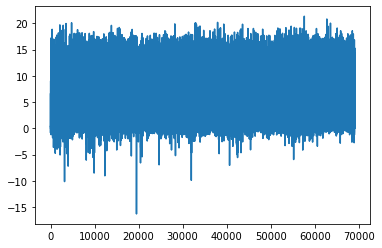

In [52]:
option = 'random'

max_episodes = 100000
losses = []
try: 
    for ep in range(1, max_episodes+1): 
        if option == 'random': 
            #l = train_step_random(reset(), agent, optimizer)
            l2 = train_step_random_v2(tf_reset_v2(), agent, optimizer)
            loss = l2.numpy()#l.numpy() + l2.numpy()
            losses.append(loss)

            if ep%100 == 0: 
                print(f"{ep} Episodes have been finished. So far: loss - {losses[-1]}     ", end = "\r" )

            if ep%2500 == 0: 
                arena(players = [random_bot(), agent], num_games = 500)
                print()

        else: 
            loss1, loss2 = train_step(reset(), agent, optimizer)
            losses.append((loss1.numpy(), loss2.numpy()))

            if ep %100 == 0: 
                print(f"{ep} Episodes have been finished. So far: loss1 - {loss} and loss2 - {loss2}    ", end = "\r" )
                
except KeyboardInterrupt: 
    print("Interrupted training, displaying current statistics                               ")

if option == "random": 
    plt.plot(range(len(losses)), losses)
else: 
    fig, axes = plt.subplots(1,2)
    a, b = zip(*losses[300:])

    axes[0].plot(range(len(a)), a)
    axes[1].plot(range(len(b)), b)

In [80]:
arena(players = [agent, random_bot()], num_games = 1000)

In [81]:
arena(players = [agent, agent], num_games = 100)

In [85]:
simulate(players = [agent, random_bot()], display = True)

player 0 thinks values are (<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[ 2.2894943, -3.5588078, -6.1133685, -0.9993383, -4.0170364,
        -1.9503982, -3.4126441,  2.4485414,  6.2898607, 15.036212 ,
        -6.402041 , -1.25827  ]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7847097]], dtype=float32)>)
Player 1 chips: 6 T's and 6 O's
Player 2 chips: 6 T's and 6 O's
  |   |   |   |   |  
  |   |   |   |   |  
  |   |   |   |   |  
  |   |   |   |   |  
action was 9 and the reward was 0

player 1 thinks values are IS A RANDOM BOT
Player 1 chips: 6 T's and 5 O's
Player 2 chips: 6 T's and 6 O's
  |   |   |   |   |  
  |   |   |   |   |  
  |   |   |   |   |  
  |   |   | O |   |  
action was 4 and the reward was 0

player 0 thinks values are (<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[ 5.6983075 , -3.764673  , -7.134369  , -2.1153278 , -6.538213  ,
        -2.343559  , -4.21098   ,  2.2303834 ,  4.562322  , 20.639086  ,
        -8.

(1, <__main__.game at 0x1d3d33cabe0>)

In [82]:
simulate(players = [agent, agent], display = True)

player 0 thinks values are (<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[ 2.2894943, -3.5588078, -6.1133685, -0.9993383, -4.0170364,
        -1.9503982, -3.4126441,  2.4485414,  6.2898607, 15.036212 ,
        -6.402041 , -1.25827  ]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7847097]], dtype=float32)>)
Player 1 chips: 6 T's and 6 O's
Player 2 chips: 6 T's and 6 O's
  |   |   |   |   |  
  |   |   |   |   |  
  |   |   |   |   |  
  |   |   |   |   |  
action was 9 and the reward was 0

player 1 thinks values are (<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[-0.20830628, -3.6928768 , -5.200972  ,  0.40047786, -0.8297248 ,
        -3.164492  , -2.9004767 ,  2.0265985 ,  8.109579  , 11.517474  ,
        -5.1710997 , -1.197225  ]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7737506]], dtype=float32)>)
Player 1 chips: 6 T's and 5 O's
Player 2 chips: 6 T's and 6 O's
  |   |   |   |   |  
  |   |   |   |  

action was 5 and the reward was 0

player 1 thinks values are (<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[ 1.4218946 , -3.871461  , -4.897306  , -1.0143162 , -0.21537204,
        -2.3836205 , -2.3489962 ,  0.91538274,  9.591419  , 17.358624  ,
        -6.852416  , -3.5118952 ]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.52039444]], dtype=float32)>)
Player 1 chips: 1 T's and 0 O's
Player 2 chips: 2 T's and 0 O's
T |   | O | O |   | T
T | O | O | O |   | T
T | O | O | O | T | T
T | O | O | O | T | O
action was 4 and the reward was 0

player 0 thinks values are (<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[ 1.7108877 , -2.8693454 , -6.229859  , -0.48378265, -5.6707554 ,
        -1.774728  , -3.6865106 ,  3.4375124 ,  2.6655018 ,  9.742342  ,
        -4.190239  ,  1.311054  ]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9531417]], dtype=float32)>)
Player 1 chips: 1 T's and 0 O's
Player 2 chips: 1 T's a

(1, <__main__.game at 0x1d3d33b1460>)

In [29]:
agent.evaluate(reset()[0])

(<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
 array([[   8.088424 ,  -74.3431   ,  222.30336  ,    3.5896626,
          149.9978   , -139.16635  ,  394.24637  ,   21.704138 ,
          -46.30921  ,  -30.399351 ,  -83.8813   , -264.43298  ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-2.728084]], dtype=float32)>)

In [53]:
simulate(players = [agent, agent], display = True)

player 0 thinks values are (<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[ -3.4284356, -20.83711  ,   0.2610071, -14.561428 , -13.153704 ,
         11.598646 , -15.956387 ,   4.3295913,  40.47456  ,  23.40714  ,
        -10.860404 ,  -8.658392 ]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7122537]], dtype=float32)>)
Player 1 chips: 6 T's and 6 O's
Player 2 chips: 6 T's and 6 O's
  |   |   |   |   |  
  |   |   |   |   |  
  |   |   |   |   |  
  |   |   |   |   |  
action was 8 and the reward was 0

player 1 thinks values are (<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[ -7.749812 , -25.141796 ,   3.4055479, -18.255762 , -14.380478 ,
         15.746751 , -21.681639 ,   4.2820807,  49.972404 ,  25.661001 ,
        -11.641884 ,  -9.526993 ]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.6585663]], dtype=float32)>)
Player 1 chips: 6 T's and 5 O's
Player 2 chips: 6 T's and 6 O's
  |   |   |   |   |  
  |  

action was 1 and the reward was 0

player 1 thinks values are (<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[  8.246423 , -34.71486  ,  11.1182995,   0.725356 , -25.427876 ,
         27.568989 , -12.925352 ,   7.175428 ,  17.529087 ,  22.859497 ,
         -9.740168 ,  -4.2615166]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9465646]], dtype=float32)>)
Player 1 chips: 0 T's and 0 O's
Player 2 chips: 0 T's and 1 O's
  | T | O | O | T | T
T | O | O | O | T | T
T | O | O | O | T | T
T | O | O | O | T | T
action was 6 and the reward was 1

Player 1 chips: 0 T's and 0 O's
Player 2 chips: 0 T's and 0 O's
O | T | O | O | T | T
T | O | O | O | T | T
T | O | O | O | T | T
T | O | O | O | T | T


(1, <__main__.game at 0x2496f7323d0>)